<a href="https://colab.research.google.com/github/Philocreation/My_Deep_learning/blob/main/Darknet_yolov3_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.임포트

In [22]:
import cv2
import matplotlib.pyplot as plt
import glob

# 1.Darknet 다운 받아서 컴파일

In [23]:
!git clone https://github.com/AlexeyAB/darknet.git

fatal: destination path 'darknet' already exists and is not an empty directory.


In [24]:
%cd darknet

[Errno 20] Not a directory: 'darknet'
/content/darknet


In [25]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_opencv.cpp:1150:10: note: ...thi

# 2.데이터 가져오기

In [26]:
! ls -al /content/darknet/laptops.zip

-rw------- 1 root root 698278 Jan  5 05:10 /content/darknet/laptops.zip


In [27]:
!rm -rf data/obj
!mkdir data/obj
!unzip /content/darknet/laptops.zip -d data/obj/laptops_labeled

Archive:  /content/darknet/laptops.zip
  inflating: data/obj/laptops_labeled/.DS_Store  
  inflating: data/obj/laptops_labeled/1.jpg  
  inflating: data/obj/laptops_labeled/1.txt  
  inflating: data/obj/laptops_labeled/10.jpg  
  inflating: data/obj/laptops_labeled/10.txt  
  inflating: data/obj/laptops_labeled/11.jpg  
  inflating: data/obj/laptops_labeled/11.txt  
  inflating: data/obj/laptops_labeled/12.jpg  
  inflating: data/obj/laptops_labeled/12.txt  
  inflating: data/obj/laptops_labeled/2.jpg  
  inflating: data/obj/laptops_labeled/2.txt  
  inflating: data/obj/laptops_labeled/3.jpg  
  inflating: data/obj/laptops_labeled/3.txt  
  inflating: data/obj/laptops_labeled/4.jpg  
  inflating: data/obj/laptops_labeled/4.txt  
  inflating: data/obj/laptops_labeled/5.jpg  
  inflating: data/obj/laptops_labeled/5.txt  
  inflating: data/obj/laptops_labeled/6.jpg  
  inflating: data/obj/laptops_labeled/6.txt  
  inflating: data/obj/laptops_labeled/7.jpg  
  inflating: data/obj/laptops_l

In [30]:
%%writefile data/obj.names
laptop
keyboard

Overwriting data/obj.names


In [47]:
%%writefile data/obj.data
classes = 2
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = ./

Overwriting data/obj.data


In [48]:
!cat data/obj.names

laptop
keyboard

In [49]:
!cat data/obj.data

classes = 2
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = ./

In [50]:
# ls -al data/obj/laptops_labeled 밑에 jpg 파일들이 있으면
images_list = glob.glob("data/obj/laptops_labeled/*[jpg|png|jpeg]")

# ls -al data/obj 밑에 jpg 파일들이 있으면
# images_list = glob.glob("data/obj/*[jpg|png|jpeg]")

print(images_list)

# Create train.txt file
file = open("data/train.txt", "w") 
file.write("\n".join(images_list)) 
file.close()

['data/obj/laptops_labeled/5.jpg', 'data/obj/laptops_labeled/10.jpg', 'data/obj/laptops_labeled/4.jpg', 'data/obj/laptops_labeled/7.jpg', 'data/obj/laptops_labeled/2.jpg', 'data/obj/laptops_labeled/6.jpg', 'data/obj/laptops_labeled/1.jpg', 'data/obj/laptops_labeled/11.jpg', 'data/obj/laptops_labeled/3.jpg', 'data/obj/laptops_labeled/9.jpg', 'data/obj/laptops_labeled/12.jpg', 'data/obj/laptops_labeled/8.jpg']


In [51]:
!cat data/train.txt

data/obj/laptops_labeled/5.jpg
data/obj/laptops_labeled/10.jpg
data/obj/laptops_labeled/4.jpg
data/obj/laptops_labeled/7.jpg
data/obj/laptops_labeled/2.jpg
data/obj/laptops_labeled/6.jpg
data/obj/laptops_labeled/1.jpg
data/obj/laptops_labeled/11.jpg
data/obj/laptops_labeled/3.jpg
data/obj/laptops_labeled/9.jpg
data/obj/laptops_labeled/12.jpg
data/obj/laptops_labeled/8.jpg

# 4.학습 관련 설정 파일 수정 

원 설정파일 yolov3.cfg를 yolv3_custom.cfg로 복사하고

복사한 설정파일을 수정

In [52]:
CUSTOM_OBJECT_NAMES = ['laptop', 'keyboard']

In [53]:
# %cd darknet

# Make a copy & rename it to yolov3_custom.cfg
!cp cfg/yolov3.cfg cfg/yolov3_custom.cfg

In [54]:
# Change classes value to your number of objects
classes = len(CUSTOM_OBJECT_NAMES)
filters = (classes + 5) * 3
max_batches = classes * 2000

if max_batches < 6000:
  max_batches = 6000
max_batches = 500

# Edit classes & filters
!sed -i 's/batch=1/batch=64/' cfg/yolov3_custom.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_custom.cfg
!sed -i 's/max_batches = 500200/max_batches = $max_batches/' cfg/yolov3_custom.cfg
!sed -i '610 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '696 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '783 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '603 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg
!sed -i '689 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg
!sed -i '776 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg

5. 학습된 YOLOv3 모델 파일 다운로드

In [55]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2022-01-05 06:56:27--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.3’

darknet53.conv.74.3 100%[===================>] 154.96M  40.4MB/s    in 4.2s    

2022-01-05 06:56:32 (36.8 MB/s) - ‘darknet53.conv.74.3’ saved [162482580/162482580]



# 6.학습 실행

In [56]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.390575), count: 1, class_loss = 0.375811, iou_loss = 0.384454, total_loss = 0.760265 
 total_bbox = 61570, rewritten_bbox = 0.690271 % 

 426: 1.477226, 1.527008 avg loss, 0.000033 rate, 5.274147 seconds, 27264 images, 0.155886 hours left
Loaded: 0.000135 seconds
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.606467), count: 10, class_loss = 1.759099, iou_loss = 1.876508, total_loss = 3.635607 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.004217, iou_loss = 0.000000, total_loss = 0.004217 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.001778, iou_loss = 0.000000, total_loss = 0.001778 
 total_bbox = 61580, rewritten_bbox = 0.690159 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) R

# 7. 탐지 실행

In [81]:
!./darknet detect cfg/yolov3_custom.cfg /content/darknet/yolov3_custom_final.weights /content/sample_data/laptop3.jfif

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcu

# 8. 테스트 해보기 

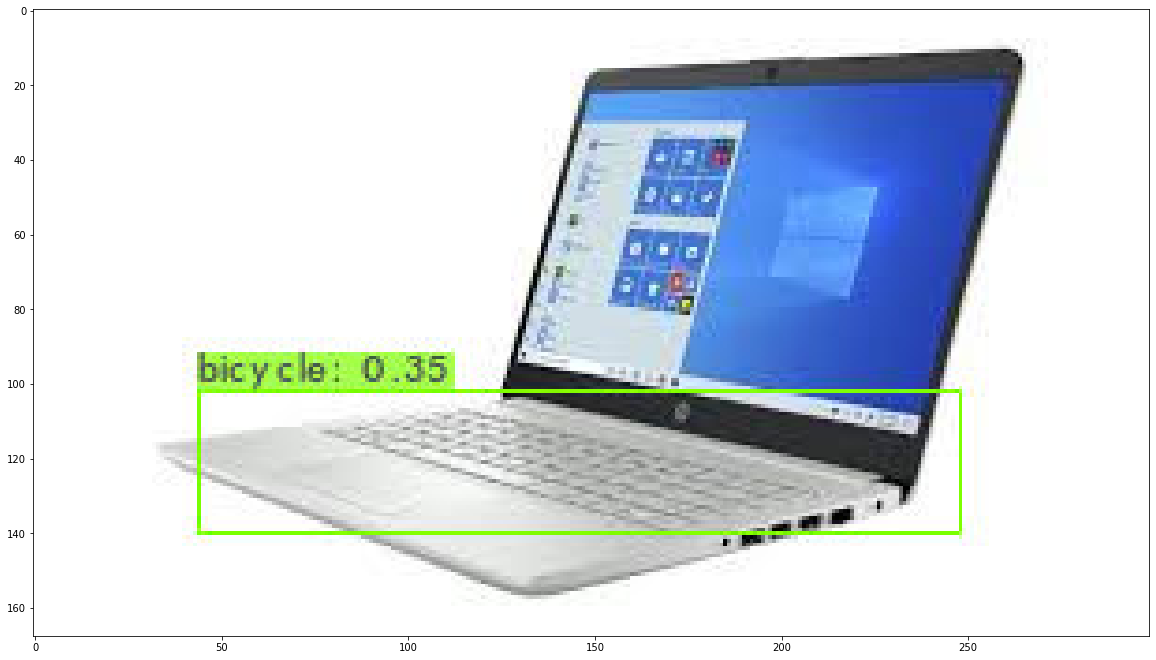

In [82]:
import cv2

pred = cv2.imread('/content/darknet/predictions.jpg')
pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(pred)

In [75]:
!./darknet detect cfg/yolov3_custom.cfg /content/darknet/yolov3_custom_final.weights /content/darknet/data/obj/laptops_labeled/4.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcu

# 모델 생성